# Gaussian Splatting w/PyCOLMAP

In [1]:
!pip install imageio-ffmpeg
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 99.1 MB/s eta 0:00:00


In [2]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pycolmap
from pathlib import Path
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

recon = pycolmap.Reconstruction('/content/drive/MyDrive/your_folder/sparse/0')
image_dir = Path('/content/drive/MyDrive/your_folder/images/')

Mounted at /content/drive


In [4]:
#### NEW2025

all_images = []
all_poses = []
all_intrinsics = []

for image_id, image in recon.images.items():
    # Load image
    img_path = image_dir / image.name
    img_pil = Image.open(img_path)
    #img_resized = img_pil.resize((800,600), Image.LANCZOS)
    img = np.array(img_pil) / 255.0
    all_images.append(img)

    # Intrinsic matrix
    cam = recon.cameras[image.camera_id]
    fx, fy = cam.params[0], cam.params[1]
    cx, cy = cam.params[2], cam.params[3]
    intrinsics = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])
    all_intrinsics.append(intrinsics)

    # Get camera pose (world-to-camera transformation)
    cam_fromworld = image.cam_from_world()

    # Extract rotation and translation
    R = cam_fromworld.rotation.matrix()  # Rotation matrix (3x3)
    t = cam_fromworld.translation        # Translation vector (3,)

    # Convert to camera-to-world (invert the transformation)
    c2w = np.eye(4)
    c2w[:3, :3] = R.T              # Transpose of rotation
    c2w[:3, 3] = -R.T @ t          # New translation
    all_poses.append(c2w)

print(len(all_images))


images = np.stack(all_images)
poses = np.stack(all_poses)
intrinsics = np.stack(all_intrinsics)

print('images.shape:', images.shape)
print('poses.shape:', poses.shape)

H, W = images.shape[1:3]
print('Image dimensions (H, W):', H, W)

# Extract camera positions
camera_positions = poses[:, :3, 3]
print("First 3 camera positions:")
print(camera_positions[0:3])

camera_rotations = poses[:, :3, :3]  # Shape: (N, 3, 3)
camera_directions = -camera_rotations[:, :, 2]  # Shape: (N, 3)
radius = np.linalg.norm(camera_positions, axis=1)
print("Camera distances from origin:")
print(radius)

27
images.shape: (27, 3024, 4032, 3)
poses.shape: (27, 4, 4)
Image dimensions (H, W): 3024 4032
First 3 camera positions:
[[-3.64555305 -1.1255223   2.53126099]
 [-3.27714578 -1.76528016  2.83611473]
 [-5.28371258 -0.85259175  2.22921704]]
Camera distances from origin:
[4.57866134 4.67968432 5.79775301 5.40022321 3.19001524 2.31627448
 4.33761907 2.31524937 3.70645635 1.89137532 4.00911452 3.06666399
 3.12152314 3.4264153  1.77851064 3.67654593 3.6730989  3.42489272
 1.88591609 3.55534718 2.7393525  2.74185816 3.55163135 1.47674185
 1.63219274 4.12038796 4.19202172]


In [5]:
#### NEW2025
# Get any image
sample_image = next(iter(recon.images.values()))
camera = recon.cameras[sample_image.camera_id]

# Get camera model information correctly
camera_model = camera.model  # This returns the model type directly
print('Camera model:', camera_model)
print('Camera parameters:', camera.params)

# Extract focal length depending on model
if camera_model == 'SIMPLE_PINHOLE':
    focal = camera.params[0]       # [f, cx, cy]
elif camera_model == 'PINHOLE':
    fx = camera.params[0]          # [fx, fy, cx, cy]
    fy = camera.params[1]
    focal = (fx + fy) / 2
elif camera_model == 'SIMPLE_RADIAL':
    focal = camera.params[0]       # [f, cx, cy, k]
elif camera_model == 'RADIAL':
    focal = camera.params[0]       # [f, cx, cy, k1, k2]
elif camera_model == 'OPENCV':
    fx = camera.params[0]          # [fx, fy, cx, cy, k1, k2, p1, p2]
    fy = camera.params[1]
    focal = (fx + fy) / 2
elif camera_model == 'OPENCV_FISHEYE':
    fx = camera.params[0]          # [fx, fy, cx, cy, k1, k2, k3, k4]
    fy = camera.params[1]
    focal = (fx + fy) / 2
else:
    # For unknown models, assume first parameter is focal length
    print(f"Warning: Unknown camera model {camera_model}, assuming first parameter is focal length")
    focal = camera.params[0]

print('Focal length:', focal)

Camera model: CameraModelId.SIMPLE_RADIAL
Camera parameters: [ 2.89058398e+03  2.01600000e+03  1.51200000e+03 -9.67240485e-02]
Focal length: 2890.583975616491


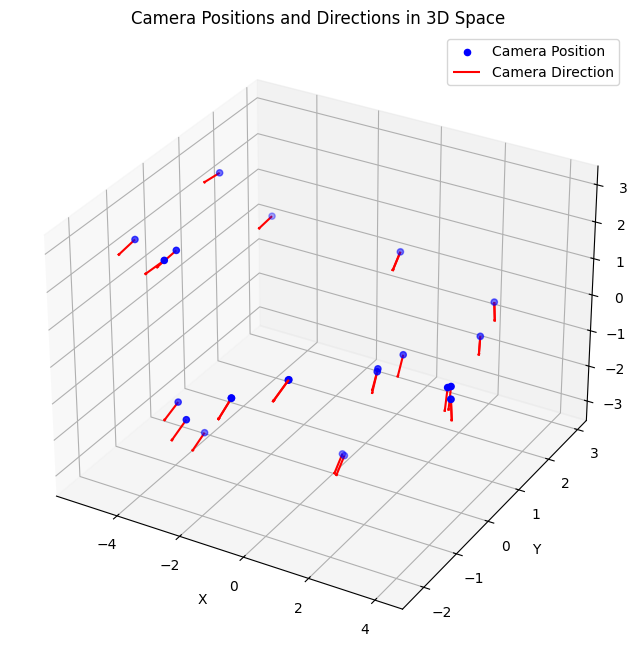

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    camera_positions[:, 0],
    camera_positions[:, 1],
    camera_positions[:, 2],
    c='blue',
    label='Camera Position'
)

for i in range(len(poses)):
    ax.quiver(
        camera_positions[i, 0],  # point(x)
        camera_positions[i, 1],  # point(y)
        camera_positions[i, 2],  # point(z)
        camera_directions[i, 0],  # vector(x)
        camera_directions[i, 1],  # vector(y)
        camera_directions[i, 2],  # vector(z)
        color='red',
        length=0.5,
        arrow_length_ratio=0.1,
        label='Camera Direction' if i == 0 else None
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Camera Positions and Directions in 3D Space')
plt.show()

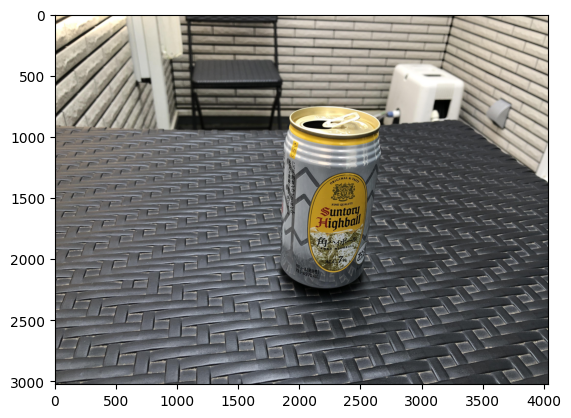

In [7]:
testimg, testpose = images[10], poses[10]
plt.imshow(testimg)
plt.show()

In [8]:
images = images[:100,...,:3] #images[:100, :, :, :3]
poses = poses[:100]

(4, 4)
[ 1.58412453 -0.68016236  3.6195204 ]


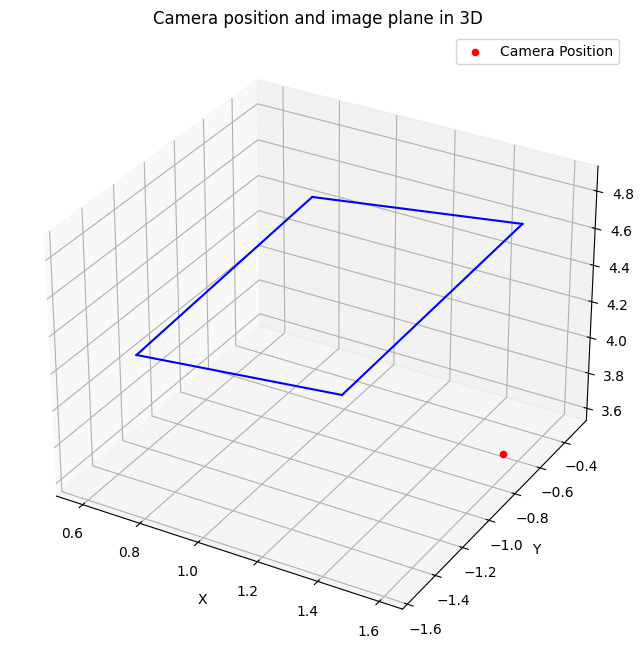

In [9]:
print(testpose.shape)

# Compute camera position (world coordinates)
camera_to_world = np.linalg.inv(testpose)
cam_pos = camera_to_world[:3,3]
print(cam_pos)

# Define image plane corners in camera coordinates
f = 1.0  # focal length (distance along Z)
img_width = 1.0
img_height = 1.0

corners_cam = np.array([
    [-img_width/2, -img_height/2, f, 1],
    [ img_width/2, -img_height/2, f, 1],
    [ img_width/2,  img_height/2, f, 1],
    [-img_width/2,  img_height/2, f, 1],
]).T  # shape (4,4)

# Transform image plane corners to world coordinates
corners_world = camera_to_world @ corners_cam
corners_world = corners_world[:3, :].T  # shape (4,3)

# Plotting
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot camera position
ax.scatter(*cam_pos, color='red', label='Camera Position')

# Plot image plane edges
for i in range(4):
    start = corners_world[i]
    end = corners_world[(i+1) % 4]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 'b-')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera position and image plane in 3D')

ax.legend()
plt.show()


---

## 🔧 Optimize NeRF

In [10]:
#### NEW2025

def posenc(x):
    rets = [x]
    for i in range(L_embed):
        for fn in [tf.sin, tf.cos]:
            rets.append(fn(2.**i * x))
    return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    input_shape = (3 + 3*2*L_embed,)
    inputs = tf.keras.Input(shape=input_shape)
    outputs = inputs

    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            # Wrap tf.concat in a Lambda layer
            outputs = tf.keras.layers.Lambda(
                lambda x: tf.concat([x[0], x[1]], axis=-1)
            )([outputs, inputs])

    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = init_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     10,240 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 295)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     75,776 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 4)         │      1,028 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 481,796 (1.84 MB)

 Trainable params: 481,796 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*1):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

## 🔧 Interactive Visualization

In [18]:
print(H,W)

3024 4032
3024.0


In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(900, 1200, focal, c2w[:3,:4]) # H2,W2 >1000
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=36)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 6.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

## 🔧 Render 360 Video